In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import pymorphy2
import nltk
import string
import re
import time
import pickle
import operator
import collections
import matplotlib.pyplot as plt
import pylab as pl
import math
import json

from collections import Counter,OrderedDict
from itertools import cycle
from scipy import spatial
from sklearn.externals import joblib
from sklearn.preprocessing import scale
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin,cosine_similarity
from sklearn.preprocessing import scale
from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec,KeyedVectors
from nltk import word_tokenize
from nltk.corpus import stopwords

In [2]:
data = pd.read_csv('vk.csv')
data = data.drop(data.columns[[0]], axis=1) 
data.shape

(40117, 2)

In [3]:
# обработка пропущенных значений - удаляем пустые строки из данных
data_upd = data.dropna(axis = 0)
data_upd.shape

(40081, 2)

In [4]:
# Сохраняем словарь в json-формат 
# json.dump(data_upd.values.tolist(),open("faq.json","w"))  

# Читаем из .json
# data_load= json.load(open("faq.json","rb"))

In [5]:
questions = data_upd['question']

In [6]:
questions.shape

(40081,)

In [7]:
stop_words = nltk.corpus.stopwords.words('russian')

In [8]:
def text_preproc_corpus(text):
    
    #apply nltk tokenization
    token_text = []
    tokens = [nltk.word_tokenize(sent) for sent in text]
    
    # delete punctuation
    text_punct = []
    s = []
    for sent in tokens:
        for word in sent:
            s.append(re.sub('[a-zA-Z]+|[\d\"\•\)\(\%\.\,\;\:\!\?\_\-\+\/\|\>\<\\\*\@\#\$\^\'\&\=\]]','',word))
        text_punct.append(s)
        s = []

    # lemmatize
    lem_text = []
    grams_exclusion = {'NUMB','PREP', 'CONJ', 'PRCL', 'INTJ','NPRO','NNP','NNPS'}
    for sent in text_punct:
        lem_sent =  [morph.parse(word)[0].normal_form for word in sent if morph.parse(word)[0].tag.POS not in grams_exclusion]
        lem_text.append(lem_sent)
          
    # delete stop words 
    stop_words = nltk.corpus.stopwords.words('russian')
    stop_words.extend(['сумма','рубль','опять','почему','снова','каков','здесь','поэтому','както','какнибудь','какиминибудь','какиелибо','какимто','банка','недалеко','никакой','ранее','ктонибудь','часть','всего','давно','тысяча','далее','много','самый','вообще','потом','добрый','деньга','какой','такой','почему','другой','нужно','время','сейчас','теперь','можно','который','как','каждый','назад','очень','что','когда','тогда','более','менее'])
    text_stop = []
    for sent in lem_text:
        t =[w for w in sent if w not in stop_words]
        text_stop.append(t)
        
    # delete words with len(words)<=3
    text_proc = []
    for sent in text_stop:
        t = [word for word in sent if len(word)>4]
        text_proc.append(t)
        
    return text_proc

In [9]:
morph = pymorphy2.MorphAnalyzer()

In [8]:
w2v = pickle.load(open('/word_vectors.pkl', "rb"))

In [9]:
qst_preproc = text_preproc_corpus(questions)

In [10]:
len(qst_preproc)

40081

In [7]:
qst_preproc_tfidf = []
for sent in qst_preproc:
    t = ' '.join([word for word in sent])
    qst_preproc_tfidf.append(t)

In [12]:
len(qst_preproc_tfidf)

40081

In [13]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), analyzer='word', min_df=10,max_df = 0.8, use_idf=True, sublinear_tf= True)
qst_tfidf = vectorizer.fit_transform(qst_preproc_tfidf)
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

In [40]:
# сохраняем vectorizer
# joblib.dump(vectorizer, 'tfidf.pkl')

# загружаем vectorizer
# vectorizer_loaded= joblib.load(open('tfidf.pkl', "rb"))

In [14]:
qst_tfidf.shape

(40081, 9850)

In [10]:
sorted_tfidf = collections.OrderedDict(sorted(tfidf.items(),key=lambda value: value[1]))
for name,freq in sorted_tfidf.items():
    print (freq,name)

In [15]:
 def featurize_w2v(model, text, vsize=300):
    f = np.zeros((len(text), vsize))
    for i,s in enumerate(text):
        for w in s:
            try:
                vec = model[w].reshape((1, vsize))*tfidf[w]
            except KeyError:
                continue
            f[i,:] = f[i,:] + vec
        if len(s) !=0: 
            f[i,:] = f[i,:] / len(s)
    return f

In [16]:
qst_w2v = featurize_w2v(w2v, qst_preproc) 
print (qst_w2v.shape)

(40081, 300)


### K-Means clustering

#### Определяем opt количество кластеров

In [ ]:
n_cl = list(range(200, 2000, 200))

In [40]:
%%time
# Inertia or within-cluster sum-of-squares (WCSS) - метрика базируется на измерении внутрикластерного расстояния между объектами 
# Эвристика - выбирают то число кластеров, начиная с которого описанный функционал падает "уже не так быстро". 

inertia = []
N_cl = range(1000,5000,500)
for i in N_cl:
    kmeans = KMeans(n_clusters = i, init='k-means++', random_state=1, max_iter=300, n_init=10, tol = 0.0001)
    inert = np.sqrt(kmeans.fit(qst_w2v).inertia_)
    inertia.append(inert)

inertia = np.asmatrix(inertia) 

CPU times: user 7h 17min 16s, sys: 3h 2min 51s, total: 10h 20min 8s
Wall time: 16h 48min 45s


In [41]:
inertia

matrix([[2384.7551934 , 2285.2974994 , 2207.52960372, 2144.3406736 ,
         2086.17302146, 2036.9517854 , 1990.32198401, 1946.549904  ]])

Text(0.5,1,'Dependency: Inertia VS Number of Clusters')

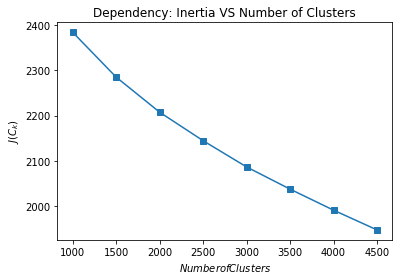

In [43]:
pl.plot(N_cl, inertia.T, marker='s')
pl.xlabel('Number of Clusters')
pl.ylabel('WCSS')
pl.title('Dependency: Inertia VS Number of Clusters')

In [11]:
%%time
# The elbow curve shows the percentage of variance explained by the number of clusters.
# When graph levels stabilized it means that adding of more clusters do not explain much more of the variance
# in our relevant variable; in this case the number of clusters will be optimal.

N = range(200,2000,200)
scores = []
for i in N:
    kmeans = KMeans(n_clusters = i, init='k-means++', random_state=1, max_iter=300, n_init=10, tol = 0.0001)
    score = kmeans.fit(qst_w2v).score(qst_w2v)
    print ("-----Score" +' ' + str(i) + ' ' + 'is executed!--------')
    scores.append(score)
scores = np.asmatrix(scores)

In [48]:
scores

matrix([[-7423787.045509  , -6686371.3897236 , -6240565.34509238,
         -5927547.84462396, -5687057.33246318, -5485010.63684543,
         -5299231.12794297, -5151255.83777629, -5002730.0683756 ]])

Text(0.5,1,'Elbow Curve')

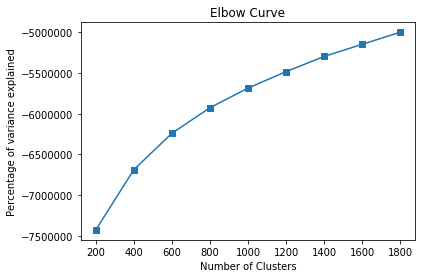

In [49]:
pl.plot(N,scores.T, marker='s')
pl.xlabel('Number of Clusters')
pl.ylabel('Percentage of variance explained')
pl.title('Elbow Curve')

#### Выполняем кластеризацию

In [24]:
kmeans = KMeans(n_clusters = 200, init='k-means++', random_state=1, max_iter=300, n_init=10, tol = 0.0001)

In [25]:
%%time
kmeans.fit_predict(qst_w2v)

CPU times: user 4min 59s, sys: 38.6 s, total: 5min 38s
Wall time: 4min 42s


array([ 90,  32, 115, ...,  94, 124, 184], dtype=int32)

In [1039]:
kmeans.labels_

array([ 90,  32, 115, ...,  94, 124, 184], dtype=int32)

In [4]:
# сохраняем обученную модель
# joblib.dump(kmeans, 'km_model.pkl')

# загружаем модель
# km = joblib.load(open('km_model.pkl', "rb"))

In [26]:
km.labels_

array([ 90,  32, 115, ...,  94, 124, 184], dtype=int32)

In [27]:
labels = km.labels_
centroids = km.cluster_centers_
clusters = len(km.cluster_centers_)

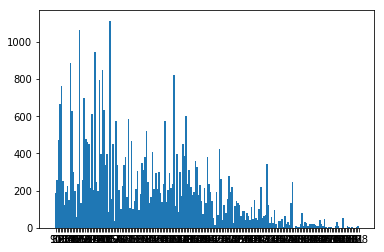

In [28]:
label, values = zip(*Counter(labels).items())

indexes = np.arange(len(label))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

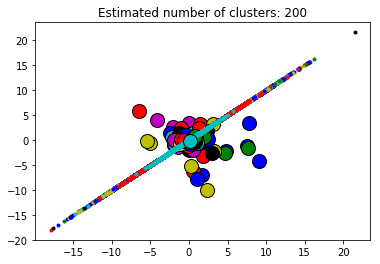

CPU times: user 2min 21s, sys: 13.1 s, total: 2min 34s
Wall time: 2min 41s


In [29]:
%%time
plt.figure(1)
plt.clf()
 
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(0,clusters), colors):
    my_members = labels == k
    cluster_center = centroids[k]
    plt.plot(qst_w2v[my_members], qst_w2v[my_members], col + '.')
    plt.plot(cluster_center[0], cluster_center[1],'o', markerfacecolor=col,markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' %clusters)
plt.show()

#### Присваиваем текстовые имена кластерами 

In [33]:
def top_n_words(questions, n):
    words = []
    for el in questions:
        words += el.split(' ')
    words_count = Counter(words).most_common()[:n]
    w = []    
    for word in words_count:
        w.append(word[0])
    return w

In [34]:
cl_qst = []*questions.shape[0]
for i in range(questions.shape[0]):
    cl_qst += [(km.labels_[i],i)]

In [1]:
clst_names_2 = []
cluster_words = [[]] * clusters
for i in range(0, clusters):
    cluster_words[i] = []

for i in range(0,len(cl_qst)):
    cur_cluster = cl_qst[i][0]
    cluster_words[cur_cluster] += [qst_preproc_tfidf[i]]
    
for i in range(0, clusters):
    clst_names_2 += [top_n_words(cluster_words[i], 6)]
    
for i in range(0, clusters):
    print ('Cluster' + str(i) + ': '+ str(clst_names_2[i]) +'\n===========')

In [38]:
# Cоздаем словарь, где ключом являются номера кластеров, а элементами - векторизованные представления документов,принадлежащие им

arr_matrix = qst_w2v
matrix_id = []
for i in range(0, arr_matrix.shape[0]):
    matrix_id += [(arr_matrix[i],i)]
    
vect_qst = [[]]*clusters
for key, cluster_id in zip(matrix_id, km.labels_):
    if len(vect_qst[cluster_id]) == 0:
        vect_qst[cluster_id] = []
    arr = key[0].tolist()
    vect_qst[cluster_id] += [(arr, key[1])]

In [39]:
# Сохраняем словарь в json-формат 
# json.dump(vect_qst,open("vect_qst.json","w"))  

# Читаем из .json
# vect_qst_loaded = json.load(open("vect_qst.json","rb"))

### Находим ответы на вопросы

#### Формат ответа: 
#### result1 = [список 5 ближайших троек вида: {вопрос, ответ, confidence}, 
#### result2 = [список названий/эталонных вопросов 5 ближайших кластеров с некоторым confidence]

In [3]:
# находим ближайший вопрос для нового обращения
text =['здравствуйте! подскажите, как оформить ипотеку онлайн?']
vec1 = featurize_w2v(w2v,text_preproc_corpus(text))
dist = []

for i in range(len(vect_qst_loaded)):
    for j in range(len(vect_qst_loaded[i])):
        similarity = 1 - spatial.distance.cosine(vec1, vect_qst_loaded[i][j][0])
        dist += [(similarity, vect_qst_loaded[i][j][1], i)]

dist.sort(reverse=True)
dist[:5]

In [2]:
result1 = []

for i in range(0, 5):
    doc_idx = dist[i][1]
    result1 += [(data_upd['question'][doc_idx], data_upd['answer'][doc_idx], dist[i][0])]

for x in result1:
    print ('Вопрос:\n' + str(x[0]) + "\n" + 'Ответ:\n' + str(x[1]) + "\n" + 'Confidence: ' + str(x[2]*100) + "\n===========")   

In [4]:
# находим ближайший кластер для нового обращения
dist_clst = []

for i in range(len(centroids)):
        similarity = 1 - spatial.distance.cosine(vec1, centroids[i])
        dist_clst += [(similarity,  i)]
dist_clst.sort(reverse=True)
dist_clst[:5]

In [5]:
result2 = []

for i in range(0, 5):
    clst_id = dist_clst[i][1]
    result2 += [(clst_id, reference_qst[clst_id][0], reference_qst[clst_id][1], dist_clst[i][0])]

for x in result2:
    print ('Имя кластера: ' + str(x[0]) + '. ' + str(x[1]) + "\n" +'Reference question: ' + str(x[2]) + "\n" + 'Confidence: ' + str(x[3]*100) + "\n===========")

#### Находим референсный (эталонный) вопрос для каждого кластера

In [6]:
from sklearn.metrics import pairwise_distances_argmin_min

closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, qst_w2v)
ref_qst = []
for i in range(0,clusters):
    ref = [str(closest[i]),questions[closest[i]]]
    ref_qst.append(ref)
    ref = []

# создаем список референсных вопросов и названий кластеров, где ключом является номер кластера    
reference_qst = []
for i in range(len(dist1_sort_top)):
    reference_qst += [(clst_names_2[i], ref_qst[i])]

for i in range(0,clusters):
    print ('Reference question, cluster ID ' + str(i) + ': ' + str(reference_qst[i]) + '\n==========')

In [1290]:
# загружаем в json базу эталонных(референсных) вопросов для каждого кластера
# json.dump(reference_qst,open("reference_qst.json","w"))  

# Читаем из .json
# reference_qst_loaded = json.load(open("reference_qst.json" ,"rb"))